# Neural Network for RUL Prediction (including engineered features)

## Introduction

This notebook focuses on designing and implementing neural network models for predicting the Remaining Useful Life (RUL) of engines using the NASA CMAPSS dataset and a baseline model. The dataset provides multivariate time-series data capturing engine operational and sensor measurements. By analyzing these sequences, we aim to estimate the RUL, which is critical for predictive maintenance and avoiding unexpected failures.

In this notebook we are going to use the **engineered** features. We use those features in the next notebook (Part II).

### Objectives
1. **Develop a Baseline Model:**
   - Implement a baseline neural network using **RNN** layers to leverage the sequential nature of the data.
   - Evaluate the baseline model's performance as a benchmark.

2. **Experiment with more complex models like GRU and Transformer-Based Models:**
   - Implement a more advanced architecture based on transformers for sequence modeling and feature extraction.
   - Compare its performance with the LSTM-based baseline model.

### Plan
1. **Prepare the Data:**
   - Use the preprocessed and scaled dataset created in previous notebooks.
   - Ensure the dataset supports both original features and optional engineered features for flexibility in experimentation.

2. **Baseline Model (LSTM):**
   - Use LSTM layers to capture temporal dependencies in the sequence data.
   - Evaluate the model's performance using Mean Squared Error (MSE) as the loss metric.

3. **Transformer-Based Model:**
   - Design a transformer architecture for sequence-to-sequence modeling.
   - Focus on capturing long-range dependencies and complex interactions among features.

4. **Model Comparison and Evaluation:**
   - Compare the models on key metrics such as Mean Absolute Error (MAE) and MSE.
   - Analyze the advantages and trade-offs of each approach.

### Why Use LSTMs and Transformers?
- **LSTMs:** 
  - Effective at capturing temporal dependencies and patterns in sequential data.
  - Provide a strong benchmark for sequence modeling tasks.
- **Transformers:**
  - Offer enhanced capability to model long-range dependencies compared to LSTMs.
  - Utilize attention mechanisms to focus on the most relevant parts of the sequence.

### Expected Outcome
By the end of this notebook, we aim to:
- Establish a strong baseline model for RUL prediction.
- Explore the potential of transformer-based models for handling sequence data.
- Gain insights into the strengths and limitations of these architectures for predictive maintenance tasks.

Let's begin by loading the prepared dataset and setting up the baseline model.


# Baseline Model: RNN-Based Approach

## Introduction
The first model we will explore for predicting Remaining Useful Life (RUL) is a baseline approach based on a **Recurrent Neural Network (RNN)**. RNNs are well-suited for sequence-based data as they are designed to handle temporal dependencies by processing sequences one step at a time, maintaining a hidden state that captures information about previous steps.

## Objective
The objective of this baseline model is to:
- Establish a foundation for sequence modeling using a simple RNN architecture.
- Capture the temporal dependencies in the NASA Turbofan Degradation dataset to predict RUL.
- Provide a baseline performance metric to compare with more advanced models like GRUs and transformers.

## Why RNNs?
Recurrent Neural Networks (RNNs) are among the simplest neural network architectures for sequence data. They work well for datasets where:
- Sequential order and temporal relationships are important.
- Shorter sequences or relatively simple temporal dynamics are present.

While RNNs have limitations in capturing long-term dependencies due to vanishing gradient problems, they offer a straightforward starting point for understanding sequence-based modeling.

## Model Architecture Outline
1. **Input Layer:**
   - Takes the sequence of sensor readings and operational settings for a fixed window of cycles as input.
   - Each sequence represents a series of measurements for a single engine.

2. **RNN Layers:**
   - A stack of RNN layers processes the sequence data, maintaining a hidden state to encode temporal dependencies.

3. **Fully Connected Layers:**
   - Outputs from the final RNN layer are passed through fully connected layers for further processing.

4. **Output Layer:**
   - A single neuron outputs the predicted RUL for the input sequence.

## Expected Outcomes
- Provide baseline results for RUL prediction using a simple RNN model.
- Understand the limitations of standard RNNs, such as difficulties in capturing long-term dependencies.
- Use this model as a benchmark to evaluate the improvements offered by more advanced architectures like GRUs and transformers.

In the next section, we will define and implement this RNN-based baseline model.


# Preparing our existing CMAPSSDataset for a sequence based network
For that see the code in v3/dataset.py.

In [1]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from codebase.v4.dataset import CMAPSSDataset, SequenceCMAPSSDataset

# Define a function to prepare the DataLoader
def prepare_sequence_dataloader(
        data_dir, data_index, feature_cols, batch_size=32, mode="train", compute_engineered_features=True, sequence_length=30):
    """
    Prepares the DataLoader for the CMAPSS dataset.
    
    Args:
        data_dir (str): Directory containing the dataset files.
        data_index (int): Index of the dataset file to load (0 to 3).
        feature_cols (list): List of feature columns to use.
        batch_size (int): Batch size for the DataLoader.
        mode (str): Mode of the dataset, "train" or "test".
        compute_engineered_features (bool): Whether to include engineered features.
        
    Returns:
        DataLoader: PyTorch DataLoader for the CMAPSS dataset.
    """
    # Initialize the dataset
    dataset = CMAPSSDataset(
        data_dir=data_dir,
        data_index=data_index,
        feature_cols=feature_cols,
        mode=mode,
        compute_engineered_features=compute_engineered_features
    )
    
    # Wrap it with the sequence-based dataset
    sequence_dataset = SequenceCMAPSSDataset(dataset, sequence_length=sequence_length)

    # Create DataLoader
    dataloader = DataLoader(sequence_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return dataloader


In [2]:
def test_sequence_dataset(dataloader, mode="train"):
    """
    Test the SequenceCMAPSSDataset and display an example output.

    Args:
        dataset (CMAPSSDataset): The original CMAPSSDataset instance.
        sequence_length (int): Length of each sequence.
        batch_size (int): Batch size for the DataLoader.
    """
    
    # Fetch one batch
    for batch_idx, batch in enumerate(dataloader):
        if mode == "train":
            sequences, targets, engine_ids, _ = batch
            print(f"Batch {batch_idx + 1}")
            print(f"Sequences Shape: {sequences.shape}")  # Expected: (batch_size, sequence_length, num_features)
            print(f"Targets Shape: {targets.shape}")  # Expected: (batch_size,)
            print(f"Sample Sequence (First in Batch):\n{sequences[0]}")
            print(f"Corresponding Target (First in Batch):\n{targets[0]}")
            print(f"Engine ID (First in batch): {engine_ids[0]}")
        else:
            sequences, engine_ids, engine_ids = batch
            print(f"Batch {batch_idx + 1}")
            print(f"Sequences Shape: {sequences.shape}")  # Expected: (batch_size, sequence_length, num_features)
            print(f"Sample Sequence (First in Batch):\n{sequences[0]}")
            print(f"Engine ID (First in batch): {engine_ids[0]}")
        break  # Only fetch the first batch for demonstration


In [3]:
import pandas as pd

# Set up paths and features
data_dir = "data/CMAPSSData"
data_index = 1  # Choose FD001, FD002, etc.

compute_engineered_features = True
sequence_length = 60
batch_size = 2048

train_data = pd.read_csv("./data/CMAPSSData/train_FD001.txt", sep=r'\s+', header=None)
train_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

constant_cols = train_data[feature_cols].nunique()
constant_cols = constant_cols[constant_cols == 1]

feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

# Prepare DataLoader
train_loader = prepare_sequence_dataloader(
    data_dir, data_index, feature_cols, 
    batch_size=batch_size, mode="train", sequence_length=sequence_length,
    compute_engineered_features=compute_engineered_features)

# Test the sequence dataset
test_sequence_dataset(train_loader, mode="train")

Batch 1
Sequences Shape: torch.Size([291, 60, 62])
Targets Shape: torch.Size([291])
Sample Sequence (First in Batch):
tensor([[-0.8639, -0.6919, -0.6328,  ...,  1.1114, -1.1580,  0.3762],
        [-1.9603, -0.3505, -1.1723,  ...,  0.9976, -1.2604, -0.4221],
        [ 0.4609,  0.3323, -0.4130,  ...,  0.8967, -1.7476,  0.1414],
        ...,
        [ 0.1868,  0.3323, -1.0324,  ...,  0.6529,  0.7298, -1.0748],
        [ 0.6893,  0.6737, -0.1732,  ...,  0.7715,  0.3295,  0.8739],
        [ 0.7807,  0.6737, -0.9125,  ...,  0.6396, -0.4595,  0.4924]])
Corresponding Target (First in Batch):
128.0
Engine ID (First in batch): 1


## The code for the grouped k-fold approach:
See explanations in previous notebook.

In [5]:
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader

# Function to implement Group k-Fold with your custom dataset
def group_kfold_cross_validation(original_dataset, sequence_length, overlap, n_splits=5, batch_size=32):
    """
    Implements Group k-Fold Cross-Validation for the CMAPSS dataset.
    
    Args:
        original_dataset (CMAPSSDataset): The original dataset instance.
        sequence_length (int): Length of each sequence.
        overlap (int): Overlap between sequences.
        n_splits (int): Number of folds for cross-validation.
        batch_size (int): Batch size for the DataLoader.
    
    Returns:
        List[Tuple[DataLoader, DataLoader]]: Training and validation DataLoaders for each fold.
    """
    # Extract engine IDs and features for grouping
    engine_ids = original_dataset.data['engine_id'].values
    features = original_dataset.data[original_dataset.feature_cols].values
    targets = original_dataset.data['RUL'].values

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=n_splits)

    fold_loaders = []  # Store DataLoaders for each fold

    # Perform Group k-Fold split (features and targets are not directly used for the split)
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(features, targets, groups=engine_ids)):
        print(f"Fold {fold + 1}/{n_splits}")
        
        # Create train and validation datasets
        train_data = original_dataset.data.iloc[train_idx]
        val_data = original_dataset.data.iloc[val_idx]

        train_dataset = SequenceCMAPSSDataset(
            dataset=CMAPSSDatasetSubset(train_data, original_dataset.feature_cols, mode="train"),
            sequence_length=sequence_length,
            overlap=overlap
        )

        val_dataset = SequenceCMAPSSDataset(
            dataset=CMAPSSDatasetSubset(val_data, original_dataset.feature_cols, mode="train"),
            sequence_length=sequence_length,
            overlap=overlap
        )

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

        fold_loaders.append((train_loader, val_loader))
    
    return fold_loaders

# Helper class to create a subset of the CMAPSSDataset
class CMAPSSDatasetSubset(CMAPSSDataset):
    def __init__(self, data_subset, feature_cols, mode):
        """
        Creates a subset of the CMAPSSDataset using the provided data.

        Args:
            data_subset (pd.DataFrame): Subset of the original dataset.
            feature_cols (list): List of feature columns to include.
            mode (str): Mode of the dataset, "train" or "test".
        """
        self.data = data_subset
        self.feature_cols = feature_cols
        self.mode = mode


In [7]:
# Initialize the dataset
dataset = CMAPSSDataset(
    data_dir=data_dir,
    data_index=data_index,
    feature_cols=feature_cols,
    mode="train",
    compute_engineered_features=compute_engineered_features
)

# Perform Group k-Fold Cross-Validation
sequence_length = 60
overlap = 10 # see explanation below
n_splits = 5
batch_size = 256

fold_loaders = group_kfold_cross_validation(
    original_dataset=dataset,
    sequence_length=sequence_length,
    overlap=overlap,
    n_splits=n_splits,
    batch_size=batch_size
)

# Access the DataLoaders for each fold
for fold, (train_loader, val_loader) in enumerate(fold_loaders):
    print(f"Fold {fold + 1}")
    
    # Training DataLoader
    print(f"  Number of training sequences: {len(train_loader.dataset)}")
    first_train_item = next(iter(train_loader))
    train_features, train_targets, train_engine_ids, cycles = first_train_item
    print(f"  Training Features Shape: {train_features.shape}")
    print(f"  Training Targets Shape: {train_targets.shape}")
    print(f"  First Training Item (Features):\n{train_features[0]}")
    print(f"  First Training Item (Target): {train_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")
    
    # Validation DataLoader
    print(f"  Number of validation sequences: {len(val_loader.dataset)}")
    first_val_item = next(iter(val_loader))
    val_features, val_targets, train_engine_ids, cycles = first_val_item
    print(f"  Validation Features Shape: {val_features.shape}")
    print(f"  Validation Targets Shape: {val_targets.shape}")
    print(f"  First Validation Item (Features):\n{val_features[0]}")
    print(f"  First Validation Item (Target): {val_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")

    break  # Only display the first fold for demonstration


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Fold 1
  Number of training sequences: 264
  Training Features Shape: torch.Size([256, 60, 62])
  Training Targets Shape: torch.Size([256])
  First Training Item (Features):
tensor([[ 0.2325,  1.3565, -1.9116,  ...,  1.6639, -0.9466, -0.9128],
        [-0.4528,  1.3565, -2.7708,  ...,  1.5951, -0.9704,  0.0604],
        [ 0.0498, -0.6919, -1.3121,  ...,  1.7334, -1.0457,  0.5441],
        ...,
        [-0.7725, -0.3505, -1.7517,  ...,  1.0397,  0.5330,  2.0103],
        [-0.6355,  1.6979, -1.5519,  ...,  0.9063,  0.8011, -1.3812],
        [ 0.0041,  0.3323, -2.0514,  ...,  0.8261,  0.5025,  0.8751]])
  First Training Item (Target): 223.0
  Engine ID (First in batch): 2
  Cycles (For first sequence in batch): tensor([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5

## Validate the grouped k-fold loaders

In [7]:
import torch

def validate_kfold_loaders(original_dataset, fold_loaders, sequence_length):
    """
    Validates the integrity of k-fold DataLoaders against the original dataset.

    Args:
        original_dataset (CMAPSSDataset): The original dataset instance.
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
        sequence_length (int): Number of time steps in each sequence.
        overlap (int): Overlap between consecutive sequences.

    Returns:
        bool: True if all validations pass, otherwise raises an AssertionError.
    """
    original_data = original_dataset.data
    used_indices = set()  # Track all rows covered across folds

    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Validating Fold {fold + 1}")
        
        # Get engine IDs for train and validation sets
        train_engines = set(train_loader.dataset.dataset.data['engine_id'])
        val_engines = set(val_loader.dataset.dataset.data['engine_id'])
        
        # Check group exclusivity
        assert train_engines.isdisjoint(val_engines), \
            f"Fold {fold + 1}: Train and validation sets share engine IDs: {train_engines & val_engines}"

        # Validate training data
        for features, targets, engine_ids, cycles in train_loader:
            for idx, (seq, target, engine_id) in enumerate(zip(features, targets, engine_ids)):
                cycle_start = int(cycles[idx, 0].item())  # Convert cycle_start to an integer

                # Check sequence correctness
                for t, cycle in enumerate(range(cycle_start, cycle_start + sequence_length)):
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) &
                        (original_data['cycle'] == float(cycle))
                    ]
                    assert not original_row.empty, \
                        f"Missing data for engine {engine_id}, cycle {cycle} in training set"

                    # Verify feature values
                    original_features = original_row.iloc[0, 2:-1].values  # Features are columns 2 to -1
                    assert torch.allclose(seq[t, 0:], torch.tensor(original_features, dtype=torch.float32)), \
                        f"Mismatch in features for engine {engine_id}, cycle {cycle}"

                # Verify RUL target
                last_cycle = cycle_start + sequence_length - 1
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == float(last_cycle))
                ]['RUL'].iloc[0]
                assert torch.isclose(target, torch.tensor(expected_rul, dtype=torch.float32)), \
                    f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"


        # Validate validation data (similar to training data)
        for features, targets, engine_ids, cycles in val_loader:
            for idx, (seq, target, engine_id) in enumerate(zip(features, targets, engine_ids)):                
                cycle_start = int(cycles[idx, 0].item())  # Convert cycle_start to an integer

                for t, cycle in enumerate(range(cycle_start, cycle_start + sequence_length)):
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) &
                        (original_data['cycle'] == float(cycle))
                    ]
                    assert not original_row.empty, \
                        f"Missing data for engine {engine_id}, cycle {cycle} in validation set"

                    original_features = original_row.iloc[0, 2:-1].values
                    assert torch.allclose(seq[t, 0:], torch.tensor(original_features, dtype=torch.float32)), \
                        f"Mismatch in features for engine {engine_id}, cycle {cycle}"

                last_cycle = cycle_start + sequence_length - 1
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == float(last_cycle))
                ]['RUL'].iloc[0]
                assert torch.isclose(target, torch.tensor(expected_rul, dtype=torch.float32)), \
                    f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"

        # Track all covered indices
        train_indices = train_loader.dataset.dataset.data.index
        val_indices = val_loader.dataset.dataset.data.index
        used_indices.update(train_indices)
        used_indices.update(val_indices)

    # Check overall coverage
    assert len(used_indices) == len(original_data), \
        "Not all rows in the original dataset are covered by the k-fold loaders"

    print("All validations passed!")
    return True

validate_kfold_loaders(dataset, fold_loaders, sequence_length=sequence_length)

Validating Fold 1
Validating Fold 2
Validating Fold 3
Validating Fold 4
Validating Fold 5
All validations passed!


True

## Inspect characteristics of each fold (to ensure they are homogenic)

Inspecting Fold 1
  Training RUL Statistics:
count    264.000000
mean      90.465912
std       57.691517
min        0.000000
25%       43.000000
50%       84.500000
75%      128.250000
max      277.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     66.000000
mean      91.272728
std       61.405720
min        1.000000
25%       44.250000
50%       87.000000
75%      128.750000
max      298.000000
Name: RUL, dtype: float64


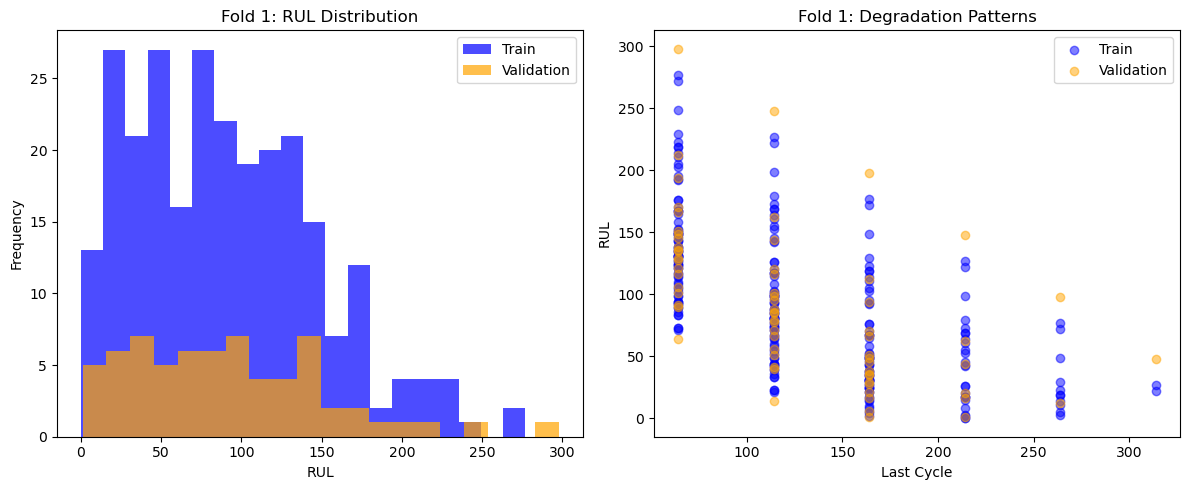

Inspecting Fold 2
  Training RUL Statistics:
count    264.000000
mean      90.518936
std       58.275475
min        0.000000
25%       43.000000
50%       86.000000
75%      129.000000
max      298.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     66.000000
mean      91.060608
std       59.135017
min        2.000000
25%       44.500000
50%       83.000000
75%      126.750000
max      277.000000
Name: RUL, dtype: float64


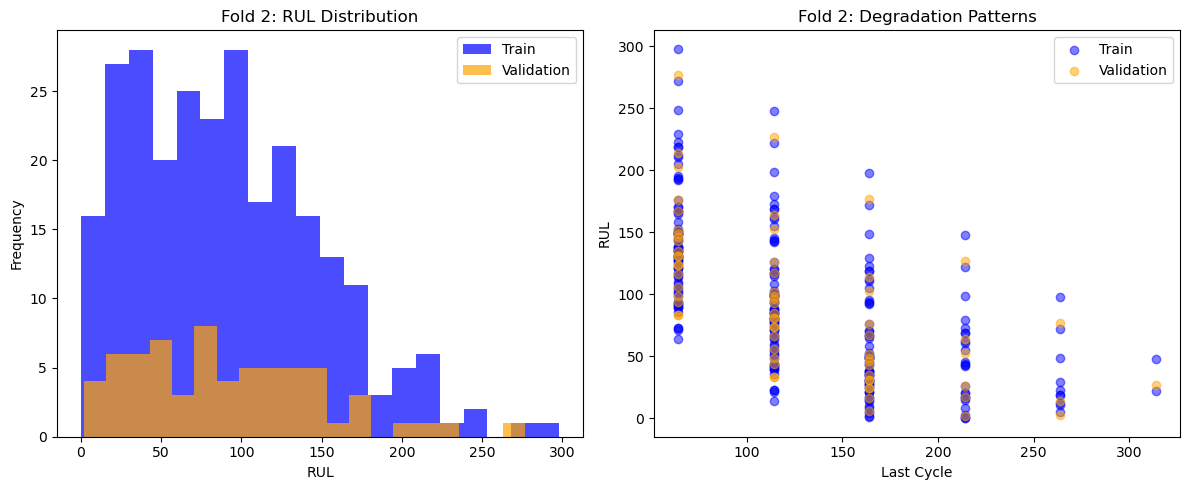

Inspecting Fold 3
  Training RUL Statistics:
count    264.000000
mean      90.606064
std       58.380123
min        0.000000
25%       43.750000
50%       85.000000
75%      129.000000
max      298.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     66.000000
mean      90.712120
std       58.717777
min        0.000000
25%       42.750000
50%       84.000000
75%      127.500000
max      272.000000
Name: RUL, dtype: float64


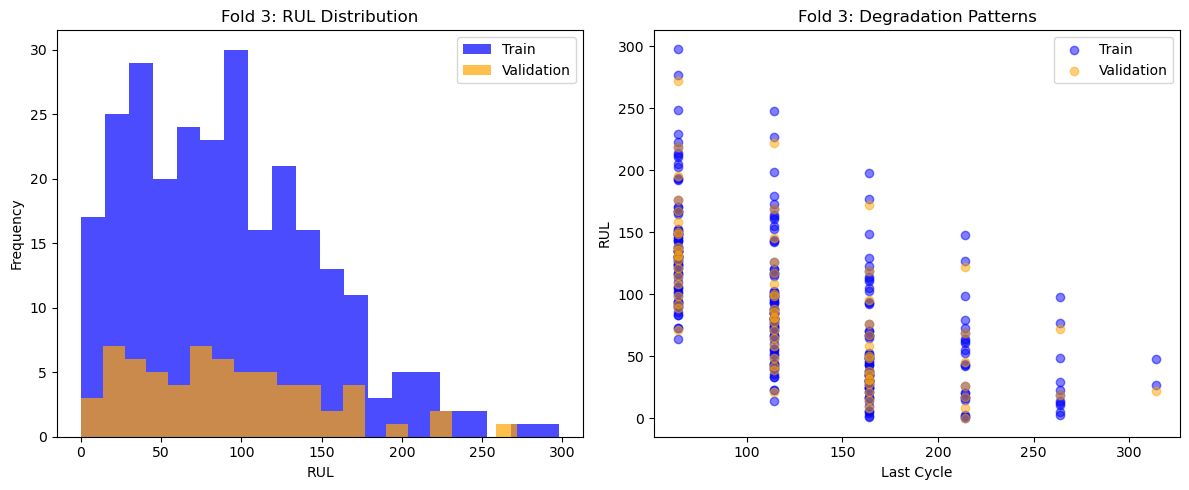

Inspecting Fold 4
  Training RUL Statistics:
count    263.000000
mean      91.121674
std       58.473782
min        0.000000
25%       44.000000
50%       85.000000
75%      128.500000
max      298.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     67.000000
mean      88.686569
std       58.300480
min        0.000000
25%       42.500000
50%       85.000000
75%      128.500000
max      249.000000
Name: RUL, dtype: float64


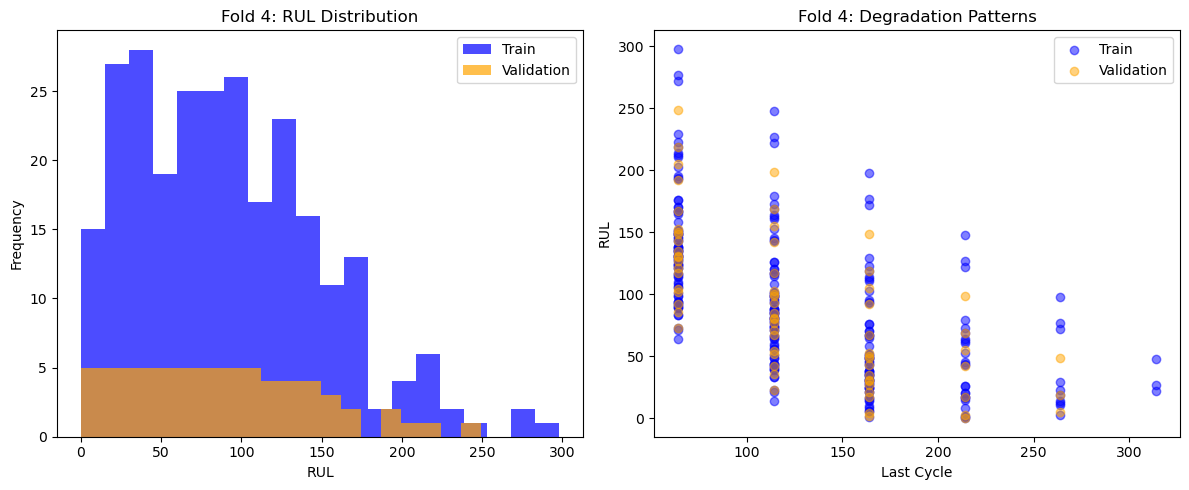

Inspecting Fold 5
  Training RUL Statistics:
count    265.000000
mean      90.426414
std       59.068291
min        0.000000
25%       43.000000
50%       85.000000
75%      128.000000
max      298.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     65.000000
mean      91.446152
std       55.804634
min       10.000000
25%       44.000000
50%       87.000000
75%      129.000000
max      229.000000
Name: RUL, dtype: float64


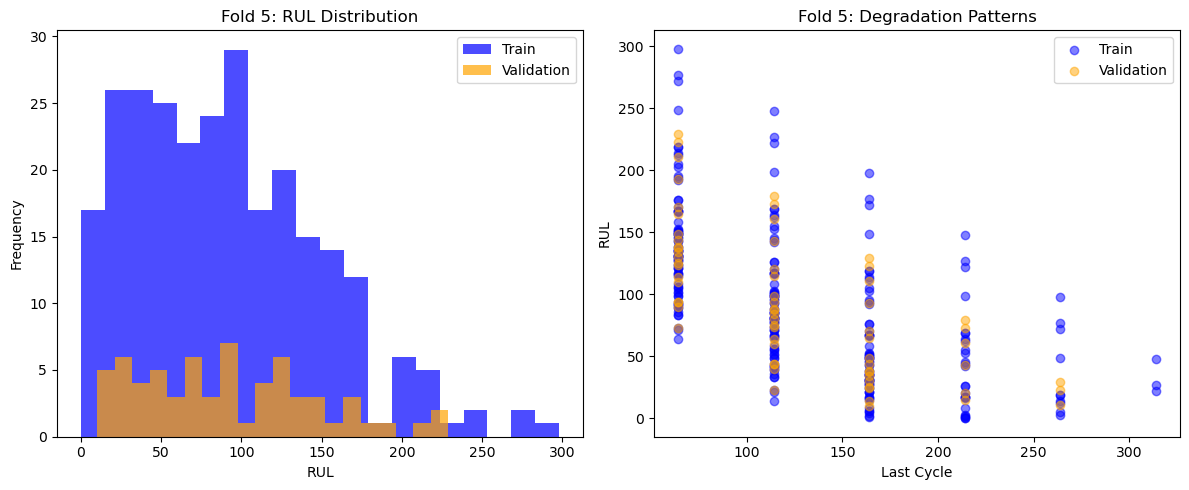

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def inspect_fold_characteristics(fold_loaders):
    """
    Inspects and visualizes RUL distribution and degradation patterns for each fold.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
    """
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Inspecting Fold {fold + 1}")
        
        # Initialize lists to collect RUL and Cycle data
        train_ruls, train_last_cycles = [], []
        val_ruls, val_last_cycles = [], []
        
        # Collect RUL and last cycles for training
        for _, targets, _, cycles in train_loader:
            train_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            train_last_cycles.extend(last_cycles.tolist())
        
        # Collect RUL and last cycles for validation
        for _, targets, _, cycles in val_loader:
            val_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            val_last_cycles.extend(last_cycles.tolist())
        
        # Convert to Pandas DataFrames for analysis
        train_df = pd.DataFrame({"RUL": train_ruls, "Last Cycle": train_last_cycles})
        val_df = pd.DataFrame({"RUL": val_ruls, "Last Cycle": val_last_cycles})
        
        # Print summary statistics
        print("  Training RUL Statistics:")
        print(train_df["RUL"].describe())
        print("  Validation RUL Statistics:")
        print(val_df["RUL"].describe())
        
        # Plot RUL distributions
        plt.figure(figsize=(12, 5))
        
        # RUL Distribution
        plt.subplot(1, 2, 1)
        plt.hist(train_df["RUL"], bins=20, alpha=0.7, label="Train", color="blue")
        plt.hist(val_df["RUL"], bins=20, alpha=0.7, label="Validation", color="orange")
        plt.xlabel("RUL")
        plt.ylabel("Frequency")
        plt.title(f"Fold {fold + 1}: RUL Distribution")
        plt.legend()

        # Degradation Patterns
        plt.subplot(1, 2, 2)
        plt.scatter(train_df["Last Cycle"], train_df["RUL"], alpha=0.5, label="Train", color="blue")
        plt.scatter(val_df["Last Cycle"], val_df["RUL"], alpha=0.5, label="Validation", color="orange")
        plt.xlabel("Last Cycle")
        plt.ylabel("RUL")
        plt.title(f"Fold {fold + 1}: Degradation Patterns")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Call the function to inspect fold characteristics
inspect_fold_characteristics(fold_loaders)

# K-Fold evaluation and development of model as preparation for a final training

In [8]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from codebase.v3.models import RNNBaselineModel
from tqdm.notebook import tqdm  # Use tqdm for Jupyter-friendly progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configuration
input_dim = len(dataset.feature_cols)  # Number of input features (contains engineered features)

def train_and_validate_kfold(fold_loaders, model_config, epochs=500, lr=0.001, patience=10):
    """
    Train and validate the model using grouped k-fold cross-validation with early stopping.
    Summarizes metrics (e.g., RMSE, Avg MSE) across all folds.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
        model_config (dict): Configuration for the model (e.g., input_dim, hidden_dim, num_layers).
        epochs (int): Maximum number of epochs to train for each fold.
        lr (float): Learning rate for the optimizer.
        patience (int): Number of epochs with no improvement before stopping.

    Returns:
        dict: Summary of metrics across all folds.
    """
    # Track metrics for all folds
    fold_metrics = {
        "train_rmse": [],
        "val_rmse": [],
        "train_avg_mse": [],
        "val_avg_mse": [],
    }

    # Loop over each fold
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Validation Fold {fold + 1}")
        
        # Initialize model, loss function, and optimizer
        model = RNNBaselineModel(**model_config)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # Early stopping variables
        best_val_loss = float('inf')
        epochs_no_improve = 0
        early_stop = False

        # Initialize progress bar for this fold
        total_batches = len(train_loader) * epochs
        with tqdm(total=total_batches, desc=f"Fold {fold + 1} Training", unit="batch") as pbar:
            for epoch in range(epochs):
                if early_stop:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
                
                model.train()
                train_loss = 0.0  # Track training loss
                num_train_sequences = len(train_loader.dataset)

                # Training loop
                for inputs, targets, _, _ in train_loader:
                    optimizer.zero_grad()
                    inputs, targets = inputs.to(device), targets.to(device)
                    
                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                    
                    # Accumulate loss
                    train_loss += loss.item() * inputs.size(0)
                    
                    # Update progress bar
                    pbar.update(1)
                
                # Compute training metrics
                avg_train_mse = train_loss / num_train_sequences
                train_rmse = avg_train_mse ** 0.5

                # Validation loop
                model.eval()
                val_loss = 0.0
                num_val_sequences = len(val_loader.dataset)
                with torch.no_grad():
                    for inputs, targets, _, _ in val_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        
                        # Forward pass
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        
                        # Accumulate validation loss
                        val_loss += loss.item() * inputs.size(0)
                
                # Compute validation metrics
                avg_val_mse = val_loss / num_val_sequences
                val_rmse = avg_val_mse ** 0.5

                # Check for early stopping
                if avg_val_mse < best_val_loss:
                    best_val_loss = avg_val_mse
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"No improvement for {epochs_no_improve} epoch(s).")

                if epochs_no_improve >= patience:
                    print("Early stopping triggered.")
                    early_stop = True

                # Print epoch metrics
                pbar.set_postfix({
                    "Epoch": f"{epoch + 1}/{epochs}",
                    "Train Loss": f"Avg MSE: {avg_train_mse:.4f}, RMSE: {train_rmse:.4f}",
                    "Val Loss:": f"Avg MSE: {avg_val_mse:.4f}, RMSE: {val_rmse:.4f}"
                })
                pbar.update(0)

        # Store fold metrics
        fold_metrics["train_rmse"].append(train_rmse)
        fold_metrics["val_rmse"].append(val_rmse)
        fold_metrics["train_avg_mse"].append(avg_train_mse)
        fold_metrics["val_avg_mse"].append(avg_val_mse)

    # Summarize metrics across all folds
    summary = {
        "mean_train_rmse": sum(fold_metrics["train_rmse"]) / len(fold_metrics["train_rmse"]),
        "mean_val_rmse": sum(fold_metrics["val_rmse"]) / len(fold_metrics["val_rmse"]),
        "mean_train_avg_mse": sum(fold_metrics["train_avg_mse"]) / len(fold_metrics["train_avg_mse"]),
        "mean_val_avg_mse": sum(fold_metrics["val_avg_mse"]) / len(fold_metrics["val_avg_mse"]),
    }

    print("\n--- k-Fold Cross-Validation Summary ---")
    for key, value in summary.items():
        print(f"{key}: {value:.4f}")

    return summary

# Define model configuration
model_config = {
    "input_dim": input_dim,
    "hidden_dim": 256,
    "num_layers": 4
}

# Train using k-fold loaders
summary = train_and_validate_kfold(fold_loaders, model_config, epochs=500, lr=0.001, patience=10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Validation Fold 1


Fold 1 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
Validation Fold 2


Fold 2 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 28
Validation Fold 3


Fold 3 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
Validation Fold 4


Fold 4 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
Validation Fold 5


Fold 5 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 27

--- k-Fold Cross-Validation Summary ---
mean_train_rmse: 77.5829
mean_val_rmse: 77.5286
mean_train_avg_mse: 6528.6029
mean_val_avg_mse: 6480.5631


# Conclusion
This concludes the notebook. We activated the engineered features in the Dataset Loaders and trained the baseline model. It was expected that training took significantly longer because of only processing 17 features, the net must now process 62 features. And the additional features have not significantly contributed to the RMSE. But this is of course also due to the simplicetly of the baseline model. And from all engineered features we should select the most relevant ones, here we have created a correlation map in the Notebook: Feature Engineering.

In the next notebook we develop a more sophisticated model and test it with and without engineered features.